In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import calendar
%matplotlib inline

In [2]:
dfReset = pd.read_csv('../data/output/output.csv', parse_dates=['created_on'], infer_datetime_format=True)
dfPublished = dfReset[:]

In [3]:
dfPublished.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462286 entries, 0 to 1462285
Data columns (total 18 columns):
id                            1462286 non-null object
created_on                    1462286 non-null datetime64[ns]
property_type                 1462286 non-null object
place_name                    1462286 non-null object
state_name                    1462286 non-null object
lat                           1122304 non-null float64
lon                           1122293 non-null float64
price                         1462286 non-null float64
currency                      1457400 non-null object
price_aprox_local_currency    1462286 non-null float64
price_aprox_usd               1462286 non-null float64
surface_total_in_m2           1079918 non-null float64
surface_covered_in_m2         233333 non-null float64
price_usd_per_m2              1016393 non-null float64
price_per_m2                  226511 non-null float64
floor                         289280 non-null float64
rooms   

___
# Publicaciones VS Tiempo
___

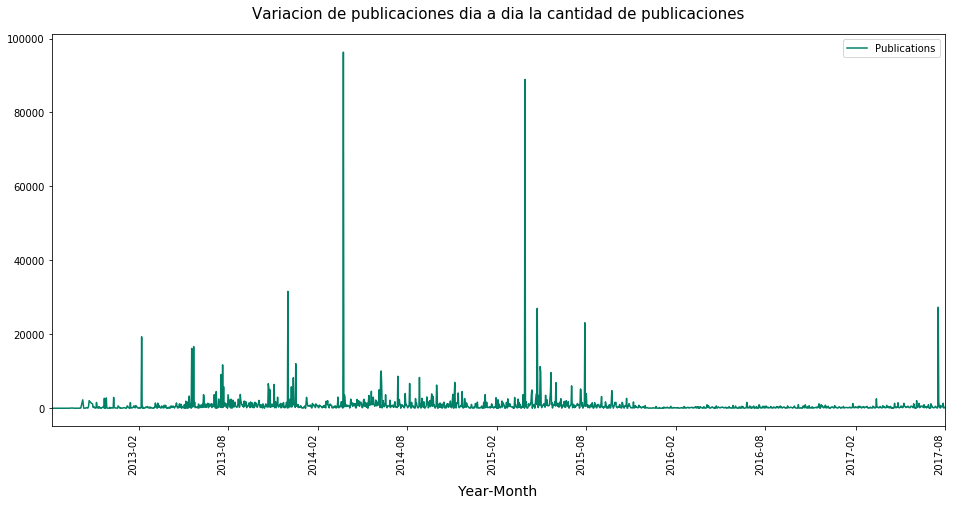

In [4]:
grouped = dfPublished[['created_on', 'id']].groupby(by='created_on').count().reset_index()
forPlot = grouped.rename(columns={'created_on':'Year-Month', 
                                  'id':'Publications'})
fig = forPlot.plot(x='Year-Month', 
                   figsize=(16, 8), 
                   colormap='summer', 
                   rot=90,
                   title="Variacion de publicaciones dia a dia la cantidad de publicaciones")
fig.xaxis.label.set_size(14)
fig.xaxis.set_label_coords(0.5, -0.15)
fig.title.set_size(15)
fig.title.set_position((0.5, 1.025));

### ¿Que pasó en esas fechas que en un solo día hubo tantas ventas?
>El gráfico es muy específico no se aprecian bien las cantidades

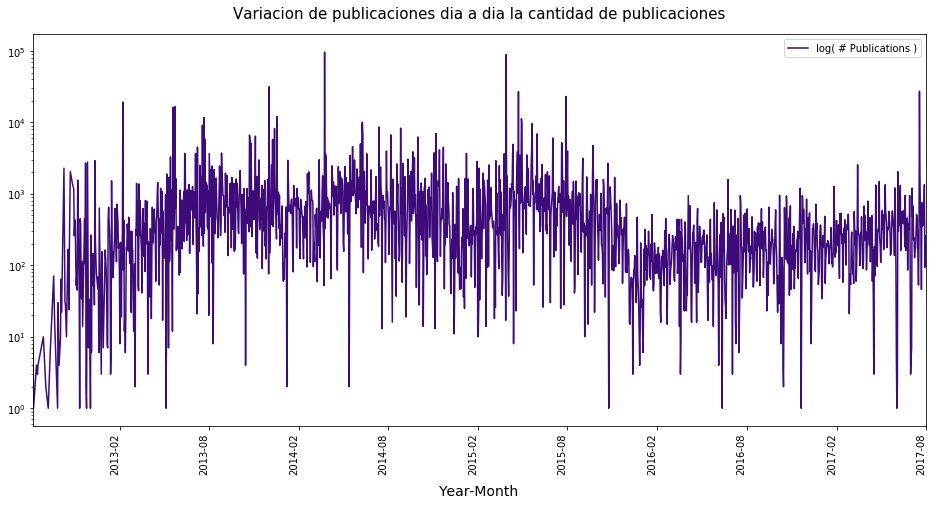

In [5]:
fig = forPlot.plot(x='Year-Month', 
                   figsize=(16, 8), 
                   color='#3e0b7a', 
                   logy=True, 
                   rot=90,
                   title="Variacion de publicaciones dia a dia la cantidad de publicaciones")
fig.xaxis.label.set_size(14)
fig.xaxis.set_label_coords(0.5, -0.15)
fig.title.set_size(15)
fig.legend().get_texts()[0].set_text("log( # Publications )")
fig.title.set_position((0.5, 1.025));

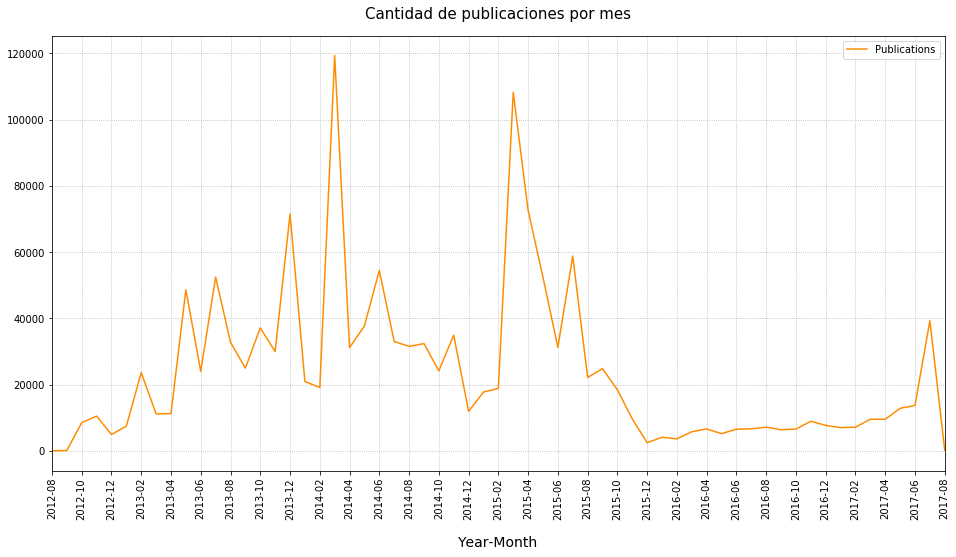

In [6]:
grouped = pd.DataFrame({'Year-Month':pd.Series(pd.to_datetime(dfPublished.created_on.dt.year.astype('str') + '-' + dfPublished.created_on.dt.month.astype('str'))), 
                        'Publications':dfPublished.id}).groupby(by='Year-Month').count()

fig = grouped.plot(x=grouped.reset_index()['Year-Month'].astype('str').str.slice(0,-3), 
                   figsize=(16, 8), 
                   xticks=range(0, len(grouped), 2), rot=90, 
                   color='DarkOrange', 
                   title="Cantidad de publicaciones por mes")
fig.xaxis.label.set_size(14)
fig.xaxis.set_label_coords(0.5, -0.15)
fig.title.set_position((0.5, 1.025))
fig.title.set_size(15)
fig.grid(linestyle='dotted')
fig.set_axisbelow(True);

### Se puede ver crecimientos y caidas notables averiguar que paso con el pais en las caídas.
> ToDo

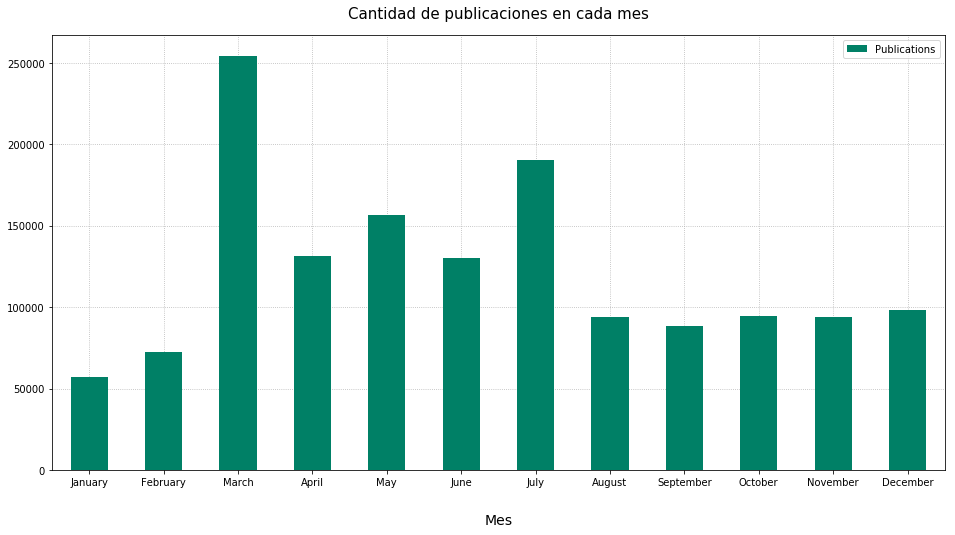

In [59]:
# ToDo: Meses donde mas se realizan publicaciones
# hacer un lmplot para el 1ro puede estar bueno
grouped = pd.DataFrame({'Mes':pd.Series(dfPublished.created_on.dt.month), 'Publications':dfPublished.id})\
            .groupby(by='Mes')\
            .count()
ax = grouped.plot(figsize=(16, 8), 
                  kind='bar', 
                  rot=0,
                  colormap='summer', 
                  title="Cantidad de publicaciones en cada mes")
ax.xaxis.set_ticklabels(calendar.month_name[1:])
ax.xaxis.label.set_size(14)
ax.xaxis.set_label_coords(0.5, -0.10)
ax.title.set_position((0.5, 1.025))
ax.title.set_size(15)
ax.grid(linestyle='dotted')
ax.set_axisbelow(True);